In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import astropy.units as u
from astropy.table import Table

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/hannah/.lightkurve/cache. Please move all the files in the legacy directory /home/hannah/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
hostname = "LHS 1140"

sectors = lk.search_lightcurve(hostname, author='SPOC')

In [3]:
sectors

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,SPOC,120,92226327,0.0
1,TESS Sector 30,2020,SPOC,20,92226327,0.0
2,TESS Sector 30,2020,SPOC,120,92226327,0.0


In [4]:
sector_numbers = []
for sector in sectors.mission: sector_numbers.append(int(sector[-2:]))
sector_numbers = np.array(sector_numbers)
np.argwhere(sector_numbers==62).shape[0]
sectors.exptime[0].value == 120

True

In [5]:
times, fluxes, texps = [], [], []
for i, secnum in enumerate(sector_numbers): 
    nsectors = np.argwhere(sector_numbers==secnum).shape[0]
    # kludgey way to get high cadence data if it exists, otherwise just normal data
    if nsectors == 1: lc_file = lk.search_lightcurve(hostname, sector=secnum,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    else: 
        if sectors.exptime[i].value == 120: continue
        else: lc_file = lk.search_lightcurve(hostname, sector=secnum,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    lc = lc_file.remove_nans().normalize().remove_outliers()
    time = lc.time.value
    flux = lc.flux
    
    with fits.open(lc_file.filename) as hdu: hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0

    times.append(time)
    fluxes.append(flux)
    texps.append(texp) # seconds

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [6]:
times

[array([1385.95396531, 1385.95535421, 1385.9567431 , ..., 1406.21618662,
        1406.21757546, 1406.21896431]),
 array([2115.89053853, 2115.89077002, 2115.8910015 , ..., 2141.81948605,
        2141.81971752, 2141.819949  ])]

In [7]:
#time = np.hstack(times)
#flux = np.hstack(fluxes)
sector_ind = 1
#sector_ind_start, sector_ind_end = 0, 6
time = np.hstack(times[sector_ind])
flux = np.hstack(fluxes[sector_ind])
texp = texps[sector_ind]

0.0002314814814814815

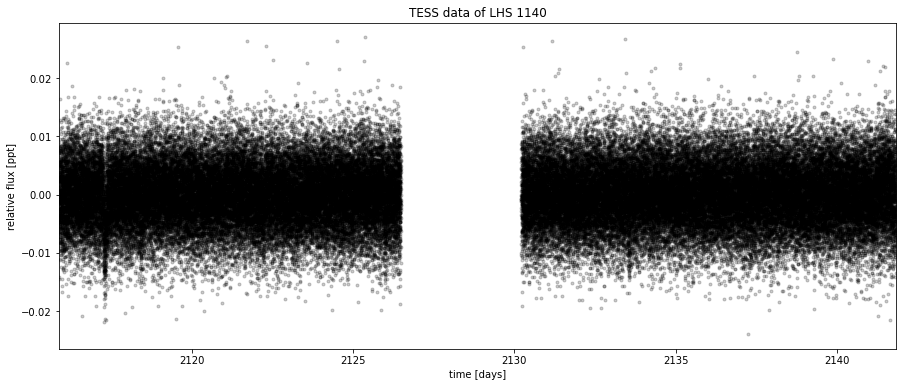

In [8]:
ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(flux - 1.0, dtype=np.float64)

%matplotlib inline
plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname}')
plt.plot(x, y, ".k", alpha=0.2)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

texp

<Quantity 20. s>

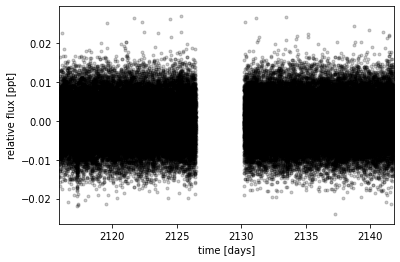

In [9]:
x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(flux - 1.0, dtype=np.float64)

plt.plot(x, y, ".k", alpha=0.2)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

(texp*u.day).to(u.s)

(2115.890538534755, 2141.8199489957983)

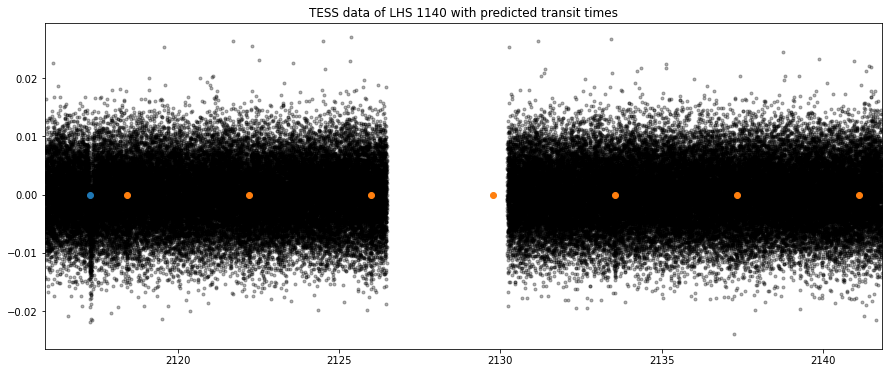

In [10]:
# priors 
T0_b        = 2458399.9303-2457000
T0_b_unc    = 0.0013
P_b         = 24.73694
P_b_unc     = 0.00041
Rp_Rs_b     = 0.07024132
Rp_Rs_b_unc = 0.0013
depth_b     = Rp_Rs_b**2
depth_b_unc = 2*Rp_Rs_b*Rp_Rs_b_unc

T0_c        = 2458389.29383-2457000
T0_c_unc    = 0.00082
P_c         = 3.77792
P_c_unc     = 0.00003
Rp_Rs_c     = 0.05022147
Rp_Rs_c_unc = 0.0011
depth_c     = Rp_Rs_c**2
depth_c_unc = 2*Rp_Rs_c*Rp_Rs_c_unc

Rs        = 0.2134
Rs_unc    = 0.0036
Ms        = 0.191
Ms_unc    = 0.012

R_pl_b      = (Rp_Rs_b * Rs*u.R_sun).to(u.R_earth).value
R_pl_c      = (Rp_Rs_c * Rs*u.R_sun).to(u.R_earth).value

T0        = np.array([T0_b, T0_c])
T0_unc    = np.array([T0_b_unc, T0_c_unc])
P         = np.array([P_b, P_c])
P_unc     = np.array([P_b_unc, P_c_unc])
depth     = np.array([depth_b, depth_c])
depth_unc = np.array([depth_b_unc, depth_c_unc])
Rp_Rs     = np.array([Rp_Rs_b, Rp_Rs_c])
Rp_Rs_unc = np.array([Rp_Rs_b_unc, Rp_Rs_c_unc])

%matplotlib inline
plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname} with predicted transit times')
plt.plot(x, y, 'k.', alpha=0.3)
n = np.arange(0, 1000)
t_b = T0_b + n*P_b
t_c = T0_c + n*P_c
plt.plot(t_b, [0 for i in t_b], 'o', color='C0', zorder=1000)
plt.plot(t_c, [0 for i in t_c], 'o', color='C1', zorder=1000)
plt.xlim(x[0], x[-1])

In [11]:
phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=0.001)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters
        M_star = Ms, Ms_unc
        R_star = Rs, Rs_unc
        #BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=0.5)
        #m_star = BoundedNormal(
        #    "m_star", mu=M_star[0], sd=M_star[1]
        #)
        #r_star = BoundedNormal(
        #    "r_star", mu=R_star[0], sd=R_star[1]
        #)
        m_star, r_star = M_star[0], R_star[0]

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=T0, sd=T0_unc, shape=2)
        log_period = pm.Normal("log_period", mu=np.log(P), sd=P_unc, shape=2)
        period = pm.Deterministic("period", tt.exp(log_period))
        
        # Fit in terms of transit depth (assuming b<1)
        #b = pm.Uniform("b", lower=0, upper=1, shape=2)
        #log_depth = pm.Normal("log_depth", mu=np.log(depth), sigma=depth_unc, shape=2)
        #ror = pm.Deterministic(
        #    "ror",
        #    star.get_ror_from_approx_transit_depth(
        #        tt.exp(log_depth), b
        #    ),
        #)
        #r_pl = pm.Deterministic("r_pl", ror * r_star)
        r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=Rp_Rs
        )
        b = xo.distributions.ImpactParameter(
            "b", ror=r, shape=2, testval=np.random.rand(2)
        )
        
        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]), shape=2)
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)
        
        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=0.1
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=0.01)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=0.1
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )
        
        print(orbit.get_planet_velocity(24578692))

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r, t=x[mask], texp=texp)
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.Matern32Term(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
                 "lc_pred_b",
            star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )
        pm.Deterministic(
                 "lc_pred_c",
            star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 1],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        #map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        #map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


In [12]:
%matplotlib inline
model0, map_soln0, extras0 = build_model()

(InplaceDimShuffle{0}.0, InplaceDimShuffle{0}.0, InplaceDimShuffle{0}.0)


ValueError: dimension mismatch

In [106]:
phase_lc

array([[-0.3       , -0.29393939, -0.28787879, -0.28181818, -0.27575758,
        -0.26969697, -0.26363636, -0.25757576, -0.25151515, -0.24545455,
        -0.23939394, -0.23333333, -0.22727273, -0.22121212, -0.21515152,
        -0.20909091, -0.2030303 , -0.1969697 , -0.19090909, -0.18484848,
        -0.17878788, -0.17272727, -0.16666667, -0.16060606, -0.15454545,
        -0.14848485, -0.14242424, -0.13636364, -0.13030303, -0.12424242,
        -0.11818182, -0.11212121, -0.10606061, -0.1       , -0.09393939,
        -0.08787879, -0.08181818, -0.07575758, -0.06969697, -0.06363636,
        -0.05757576, -0.05151515, -0.04545455, -0.03939394, -0.03333333,
        -0.02727273, -0.02121212, -0.01515152, -0.00909091, -0.0030303 ,
         0.0030303 ,  0.00909091,  0.01515152,  0.02121212,  0.02727273,
         0.03333333,  0.03939394,  0.04545455,  0.05151515,  0.05757576,
         0.06363636,  0.06969697,  0.07575758,  0.08181818,  0.08787879,
         0.09393939,  0.1       ,  0.10606061,  0.1

0 1385.941465292972 1406.2189643114145
1 2115.891117243788 2141.810111400904


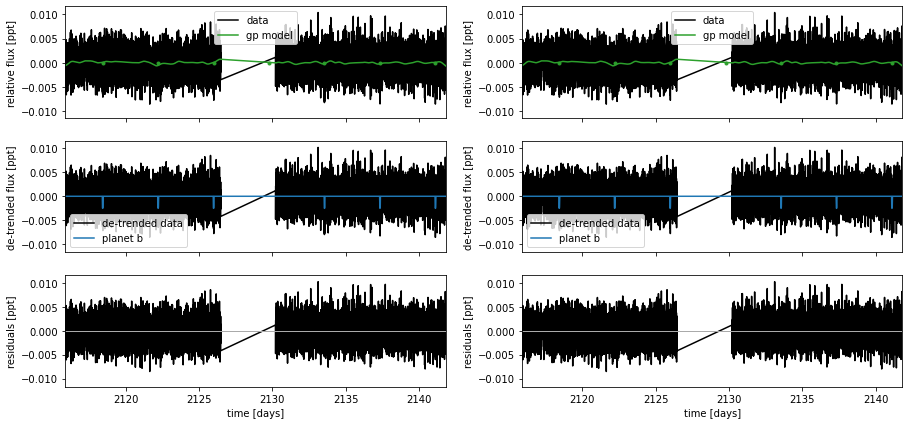

In [41]:
%matplotlib inline
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.plot(t, [0 for i in t], '.', color='C2', zorder=1000)
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    #ax.plot(t, [0 for i in t], '.', color='C0', zorder=1000)
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)

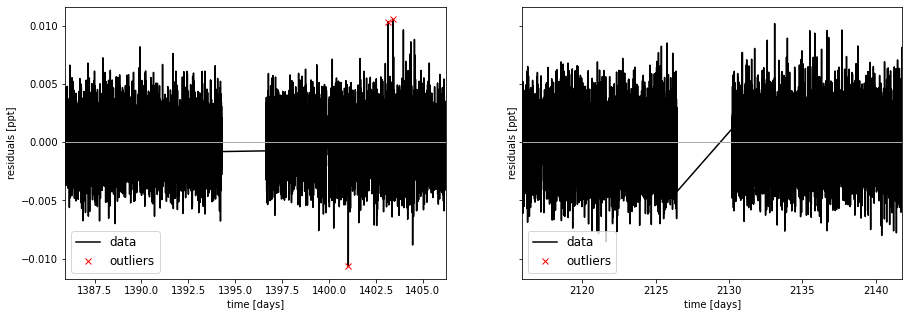

In [44]:
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 133689.53066351326 -> 133689.56846885374
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 133689.56846885374 -> 133689.56846885418
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 133689.56846885418 -> 133689.56849002794
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.56849002792 -> 133689.56849002792
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 133689.56849002794 -> 133689.5684959154
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.5684959154 -> 133689.5684959154
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 133689.5684959154 -> 133689.5684969296
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.5684969296 -> 133689.56849693094
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 133689.56849693094 -> 133689.56849693094


0 1385.941465292972 1406.2189643114145
1 2115.891117243788 2141.810111400904


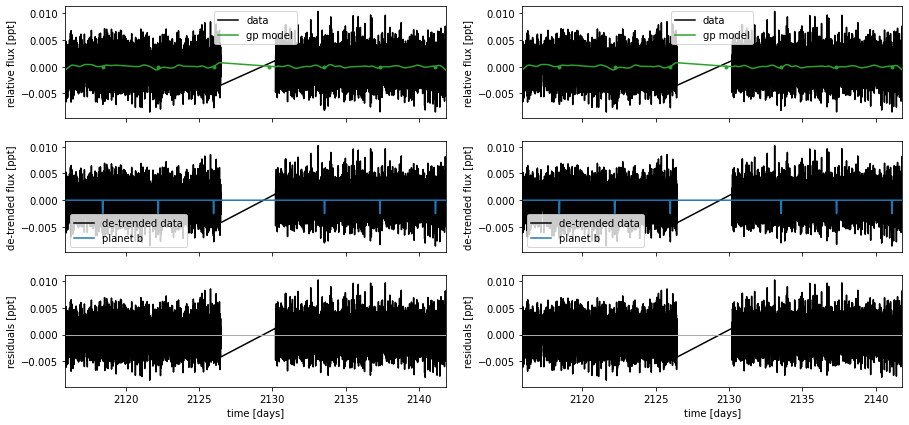

In [45]:
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

In [59]:
with model:
    trace = pm.sample(
        tune=500,
        draws=1000,
        start=map_soln,
        cores=1,
        chains=2,
        #target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 4252 seconds.


In [60]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        #"r_star",
        #"m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,-1.467,1.109,-3.037,-0.116,0.017,0.013,4236.0,4577.0,1.0
ecc,0.195,0.159,0.000,0.499,0.004,0.003,1874.0,1630.0,1.0
r_pl,0.010,0.000,0.010,0.011,0.000,0.000,2223.0,1676.0,1.0
b,0.262,0.198,0.000,0.627,0.005,0.004,2024.0,1299.0,1.0
t0,1389.294,0.001,1389.293,1389.295,0.000,0.000,2517.0,2360.0,1.0
period,3.778,0.000,3.778,3.778,0.000,0.000,2030.0,1618.0,1.0
u_star[0],0.185,0.187,0.000,0.506,0.003,0.003,3572.0,2504.0,1.0
u_star[1],0.253,0.276,-0.170,0.832,0.005,0.003,3152.0,2873.0,1.0
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,6067.0,4034.0,1.0


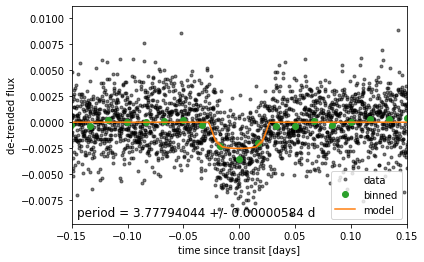

In [61]:
%matplotlib inline
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras0["gp_pred"] + map_soln0["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
plt.figure(figsize=(15, 8))
x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y - gp_mod, ".k", alpha=0.5, label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.15, 0.15, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.8f} +/- {1:.8f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

In [62]:
print("Period:")
print("    ", np.median(flat_samps["period"]), '+/-', np.std(flat_samps["period"]))
print("T0:")
print("    ", np.median(flat_samps["t0"])+2457000, '+/-', np.std(flat_samps["t0"]))
print("ecc:")
print("    ", np.median(flat_samps["ecc"]), '+/-', np.std(flat_samps["ecc"]))

Period:
     3.777939728053708 +/- <xarray.DataArray 'period' ()>
array(5.83523921e-06)
T0:
     2458389.2942323107 +/- <xarray.DataArray 't0' ()>
array(0.00062395)


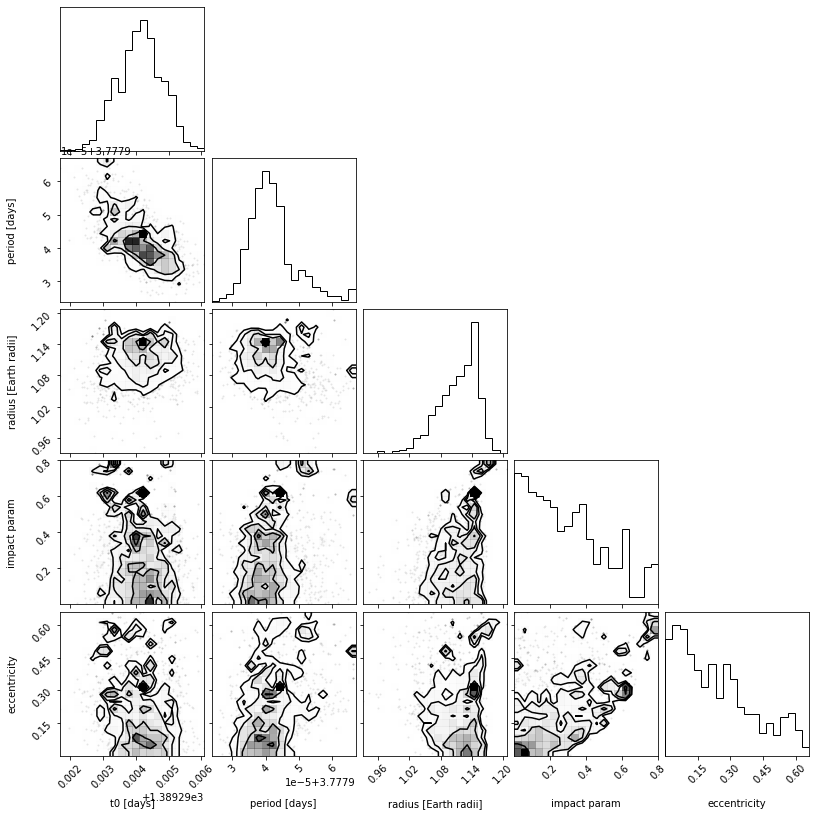

In [54]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["t0", "period", "r_earth", "b", "ecc"],
    labels=[
        "t0 [days]",
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)

In [151]:
transit_table = Table()
transit_table['#time'] = x+2457000
transit_table['flux'] = y + 1
transit_table['error'] = np.array([np.std(y) for i in y])


ascii.write(transit_table, f'../Solve_Systems/{starname.replace(" ", "")}/{starname.replace(" ", "")}.TESS.Sector{sector_numbers[sector_ind]}.tran.dat',
                        overwrite=True)
#ascii.write(transit_table, f'../Solve_Systems/{starname.replace(" ", "")}/{starname.replace(" ", "")}.TESS.Sector{sector_numbers[sector_ind_start]}-{sector_numbers[sector_ind_end-1]}.tran.dat',
#            overwrite=True)

### Getting some RV data and putting it in ExofastV2 format

In [175]:
RVs = ascii.read(f'/home/hannah/Research/Proposals/Telescope/JWST/Cycle02/RockyPlanetOccultations/Solve_Systems/{hostname.replace(" ","")}/LHS1140_LilloBox_RV_ESPRESSOpost.txt')
RVs

col1,col2,col3,col4,col5,col6
float64,float64,float64,float64,float64,str12
2458668.793097,-13.20749,0.0014,3.8774,0.0028,ESPRESSOpost
2458670.848602,-13.2098,0.00098,3.8783,0.002,ESPRESSOpost
2458673.828455,-13.2123,0.00094,3.8833,0.0019,ESPRESSOpost
2458674.908062,-13.2114,0.00084,3.8765,0.0017,ESPRESSOpost
2458675.909342,-13.21146,0.00087,3.8786,0.0017,ESPRESSOpost
2458676.871793,-13.21448,0.00081,3.8796,0.0016,ESPRESSOpost
2458676.899465,-13.21515,0.00076,3.8804,0.0015,ESPRESSOpost
2458677.884279,-13.21422,0.00081,3.8757,0.0016,ESPRESSOpost
2458679.823585,-13.20853,0.00099,3.8721,0.002,ESPRESSOpost


In [171]:
rvs = Table()
rvs['#BJD_TBD'] = RVs['col1']
rvs['RV'] = RVs['col2']
rvs['RV_err'] = RVs['col3']
rvs

#BJD_TBD,RV,RV_err
float64,float64,float64
2458668.793097,-13.20749,0.0014
2458670.848602,-13.2098,0.00098
2458673.828455,-13.2123,0.00094
2458674.908062,-13.2114,0.00084
2458675.909342,-13.21146,0.00087
2458676.871793,-13.21448,0.00081
2458676.899465,-13.21515,0.00076
2458677.884279,-13.21422,0.00081
2458679.823585,-13.20853,0.00099


In [172]:
ascii.write(rvs, f'/home/hannah/Research/Proposals/Telescope/JWST/Cycle02/RockyPlanetOccultations/Solve_Systems/{hostname.replace(" ","")}/{hostname.replace(" ","")}.ESPRESSOpost.rv', overwrite=True)

In [173]:
starname.replace(' ','')

'LHS1140'